In [1]:
# Only execute on Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install transformer_lens

    # Code to make sure output widgets display
    from google.colab import output

    output.enable_custom_widget_manager()

    !wget -q https://github.com/EffiSciencesResearch/ML4G-2.0/archive/refs/heads/master.zip
    !unzip -o /content/master.zip 'ML4G-2.0-master/workshops/transformer_interp/*'
    !mv --no-clobber ML4G-2.0-master/workshops/transformer_interp/* .
    !rm -r ML4G-2.0-master

    print("Imports & installations complete!")

else:
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
 

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G-2.0/blob/master/workshops/transformer_interp/exercise_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this exercise, we will take a closer look at some of the methods that deal with features in transformers. In particular, we will implement a part of [logit lens](https://arxiv.org/pdf/2303.08112.pdf) and [activation addition](https://arxiv.org/pdf/2308.10248.pdf).



In [3]:
import os

os.environ["ACCELERATE_DISABLE_RICH"] = "1"

import torch as t
import numpy as np
import matplotlib.pyplot as plt
from einops import repeat

# now, we import pca
from sklearn.decomposition import PCA

from transformer_lens import HookedTransformer

t.set_grad_enabled(False)
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

from tests import test_logit_lens_analysis, test_prompt_to_residual_stream_activations



## Loading and Running Models

TransformerLens comes loaded with more than 40 open-source GPT-style models. You can load any of them with HookedTransformer.from_pretrained(MODEL_NAME). For this demo notebook, we'll look at GPT-2 Small, an 80M parameter model. See the Available Models section for info on the rest.


In [4]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")
gpt2_tokenizer = gpt2_small.tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Caching all Activations

The first basic operation when doing mechanistic interpretability is to break open the black box of the model and look at all of the internal activations of a model. This can be done with `logits, cache = model.run_with_cache(tokens)`. Let's try this out, on the first sentence from the GPT-2 paper.

<details>
<summary>Aside - a note on <code>remove_batch_dim</code></summary>

Every activation inside the model begins with a batch dimension. Here, because we only entered a single batch dimension, that dimension is always length 1 and kinda annoying, so passing in the `remove_batch_dim=True` keyword removes it.

`gpt2_cache_no_batch_dim = gpt2_cache.remove_batch_dim()` would have achieved the same effect.
</details>

In [5]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = gpt2_small.to_tokens(gpt2_text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)

Here, `cache` is a `Cache` object, which acts as a dictionary containing all the activations in the model. The keys are the names of the layers, and the values are the activations. The activations are represented as `torch.Tensor`s, allowing for a wide range of operations to be performed on them, such as plotting, saving them to disk, etc.


In [6]:
for position in gpt2_cache.keys():
    print(f"Layer {position} has shape {gpt2_cache[position].shape}")

Layer hook_embed has shape torch.Size([33, 768])
Layer hook_pos_embed has shape torch.Size([33, 768])
Layer blocks.0.hook_resid_pre has shape torch.Size([33, 768])
Layer blocks.0.ln1.hook_scale has shape torch.Size([33, 1])
Layer blocks.0.ln1.hook_normalized has shape torch.Size([33, 768])
Layer blocks.0.attn.hook_q has shape torch.Size([33, 12, 64])
Layer blocks.0.attn.hook_k has shape torch.Size([33, 12, 64])
Layer blocks.0.attn.hook_v has shape torch.Size([33, 12, 64])
Layer blocks.0.attn.hook_attn_scores has shape torch.Size([12, 33, 33])
Layer blocks.0.attn.hook_pattern has shape torch.Size([12, 33, 33])
Layer blocks.0.attn.hook_z has shape torch.Size([33, 12, 64])
Layer blocks.0.hook_attn_out has shape torch.Size([33, 768])
Layer blocks.0.hook_resid_mid has shape torch.Size([33, 768])
Layer blocks.0.ln2.hook_scale has shape torch.Size([33, 1])
Layer blocks.0.ln2.hook_normalized has shape torch.Size([33, 768])
Layer blocks.0.mlp.hook_pre has shape torch.Size([33, 3072])
Layer bloc

Here is an example of how one could unembed the residual stream from the cache, should that ever prove to be useful:


In [7]:
residual_stream_activation = gpt2_cache["blocks.11.ln2.hook_normalized"]
unembedded_output = gpt2_small.unembed(residual_stream_activation[None])

## Logit Lens
Logit Lens is a method to look into the processes going on inside a transformer model. Normally, we just take the unembedding of the final layer of the model as its prediction of the next token. The idea behind Logit Lens is to look at the unembeddings of all the layers of the model and see how the model's best guess of what the next token is changes as we go through the layers.
When looking at the unembeddings of the residual stream, we visualize two things:
- What is the most likely token at each layer.
- How far does the prediction of this layer deviate from the final prediction of the model (as measured by the KL divergence).
<details>
<summary>KL Divergence</summary>
       
The KL divergence is a measure of how much two probability distributions differ. In this case, we are comparing the distribution of the final layer's unembedding to the distribution of the unembedding of the layer we are looking at.
Mathematically, the KL divergence is defined as:
$$
D_{KL}(P||Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}
$$
Here \(P\) and \(Q\) are the two distributions we are comparing, and \(i\) is the index of the token we are looking at.
The way that the KL divergence is implemented in torch can be quite confusing:
```python
torch.nn.functional.kl_div(p, q)
```


In [8]:
def plot_logit_lens(tokenizer, token_list, top_tokens, kl_div):
    seq_len, layers = top_tokens.shape
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    # Create a color map based on the KL divergence values
    cmap = plt.cm.Reds
    norm = plt.Normalize(vmin=t.min(kl_div), vmax=t.max(kl_div))
    # Set the x-axis limits to include the last row
    ax.set_xlim(0, seq_len)
    ax.set_ylim(0, layers)
    # Create a grid of boxes
    for i in range(seq_len):
        for j in range(layers):
            # Get the top token and KL divergence value for the current box
            token_id = top_tokens[i, j]
            kl_value = kl_div[i, j]
            # Decode the token ID to get the corresponding token
            token = tokenizer.decode([token_id])
            # Set the color of the box based on the KL divergence value
            color = cmap(norm(kl_value))
            # Create a rectangle patch for the box
            rect = plt.Rectangle((i, j), 1, 1, edgecolor="black", facecolor=color)
            ax.add_patch(rect)
            # Add the decoded token text to the box
            ax.text(i + 0.5, j + 0.5, token, ha="center", va="center", fontsize=8)
    # Set the x-axis labels (decoded tokens from the token list)
    ax.set_xticks(np.arange(seq_len) + 0.5)
    ax.set_xticklabels(
        [tokenizer.decode([token_id]) for token_id in token_list], rotation=45, ha="right"
    )
    # Set the y-axis labels (shifted token list)
    ax.set_yticks(np.arange(layers))
    ax.set_yticklabels([str(i) for i in range(layers)], fontsize=8)
    # Set the plot title and labels
    ax.set_title("Token Grid with KL Divergence")
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Layers")
    # Add a color bar to represent the KL divergence values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("KL Divergence")
    # Adjust the plot layout and display it
    plt.tight_layout()
    plt.show()

Now it is your turn to implement the analysis, underlying logit lens.
 - retrieve the residual stream activations, given the prompt
 - unembedd the residual stream activations, and get the probabilityd distribution of the next token at each layer
 - make a tensor of the the most likely token at each layer, for each token
 - calculate the KL divergence between the final prediction, and the prediction at each layer

In [18]:
def logit_lens_analysis(input_prompt: str):
    """
    Performs logit lens analysis on the given input prompt.

    Args:
        input_prompt (str): The input prompt to analyze.

    Returns:
        tuple: A tuple containing the following:
            - tokens (list): The tokenized input prompt.
            - top_unembedded_residual_stream_caches (torch.Tensor): The top unembedded residual stream caches.
            - kl_divergences (torch.Tensor): The KL divergences between the unembedded residual stream caches and the final logits.
    """
    # Tokenize the input prompt
    tokens = gpt2_small.to_tokens(input_prompt)

    # Run the model with caching
    final_logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)

    # Get the number of layers in the model
    num_layers = len(gpt2_small.blocks)

    # Extract the residual stream caches from the cache
    residual_stream_caches = [cache[f"blocks.{i}.ln2.hook_normalized"] for i in range(num_layers)]

    # Stack the residual stream caches along the layer dimension
    residual_stream_caches = t.stack(residual_stream_caches, dim=1)

    # Unembed the residual stream caches
    unembedded_residual_stream_caches = gpt2_small.unembed(residual_stream_caches)

    # Transform the unembedded residual stream caches into log probabilities
    unembedded_residual_stream_caches = unembedded_residual_stream_caches.log_softmax(dim=-1)

    print(unembedded_residual_stream_caches.shape)
    # Get the top unembedded residual stream caches
    top_unembedded_residual_stream_caches = t.argmax(unembedded_residual_stream_caches, dim=-1)

    print(top_unembedded_residual_stream_caches.shape)

    # Create a tensor of the same shape as the final logits of the model at each position
    final_logits = repeat(final_logits[0], 'nb_tokens vocab -> nb_tokens layer vocab', layer=num_layers)
    print(final_logits.shape)


    # Convert the final logits to probabilities
    final_probs = final_logits.softmax(dim=-1)

    # Calculate the KL divergences between the unembedded residual stream caches and the final logits
    kl_divergences = t.nn.functional.kl_div(unembedded_residual_stream_caches, final_probs, reduction="none").sum(-1)

    return tokens, top_unembedded_residual_stream_caches, kl_divergences


test_logit_lens_analysis(logit_lens_analysis, gpt2_small)

torch.Size([11, 12, 50257])
torch.Size([11, 12])
torch.Size([11, 12, 50257])
Logit lens analysis test passed


<details>
<summary>Solution</summary>

```python


def logit_lens_analysis(input_prompt: str):
    """
    Performs logit lens analysis on the given input prompt.

    Args:
        input_prompt (str): The input prompt to analyze.

    Returns:
        tuple: A tuple containing the following:
            - tokens (list): The tokenized input prompt.
            - top_unembedded_residual_stream_caches (torch.Tensor): The top unembedded residual stream caches.
            - kl_divergences (torch.Tensor): The KL divergences between the unembedded residual stream caches and the final logits.
    """
    # Tokenize the input prompt
    tokens = gpt2_small.to_tokens(input_prompt)

    # Run the model with caching
    final_logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)

    # Get the number of layers in the model
    num_layers = len(gpt2_small.blocks)

    # Extract the residual stream caches from the cache
    residual_stream_caches = [cache[f"blocks.{i}.ln2.hook_normalized"] for i in range(num_layers)]

    # Stack the residual stream caches along the layer dimension
    residual_stream_caches = t.stack(residual_stream_caches, dim=1)

    # Unembed the residual stream caches
    unembedded_residual_stream_caches = gpt2_small.unembed(residual_stream_caches)

    # Transform the unembedded residual stream caches into log probabilities
    unembedded_residual_stream_caches = unembedded_residual_stream_caches.log_softmax(dim=-1)

    # Get the top unembedded residual stream caches
    top_unembedded_residual_stream_caches = t.argmax(unembedded_residual_stream_caches, dim=-1)

    # Create a tensor of the same shape as the final logits of the model at each position
    final_logits = repeat(final_logits[0], 'nb_tokens vocab -> nb_tokens layer vocab', layer=num_layers)

    # Convert the final logits to probabilities
    final_probs = final_logits.softmax(dim=-1)

    # Calculate the KL divergences between the unembedded residual stream caches and the final logits
    kl_divergences = t.nn.functional.kl_div(unembedded_residual_stream_caches, final_probs, reduction='none').sum(-1)

    return tokens, top_unembedded_residual_stream_caches, kl_divergences
test_logit_lens_analysis(logit_lens_analysis, gpt2_small)


```

</details>

torch.Size([8, 12, 50257])
torch.Size([8, 12])
torch.Size([8, 12, 50257])


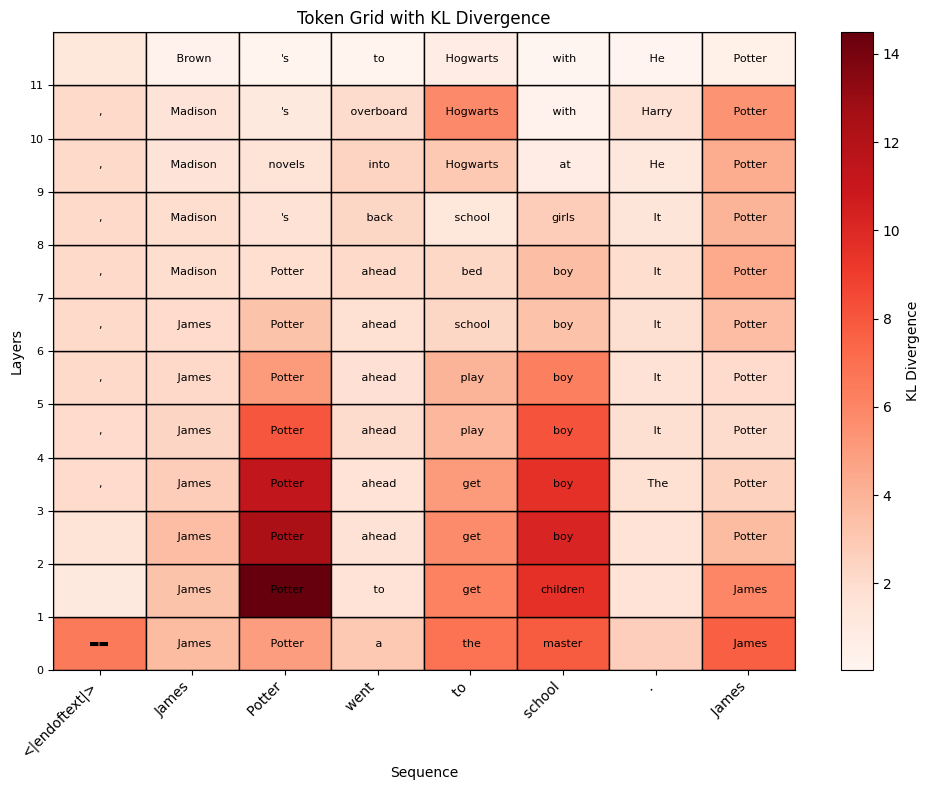

In [19]:
text = "James Potter went to school. James"
tokens, top_unebedded_residual_stream_caches, kl_divergences = logit_lens_analysis(text)
plot_logit_lens(gpt2_tokenizer, tokens[0], top_unebedded_residual_stream_caches, kl_divergences)

torch.Size([5, 12, 50257])
torch.Size([5, 12])
torch.Size([5, 12, 50257])


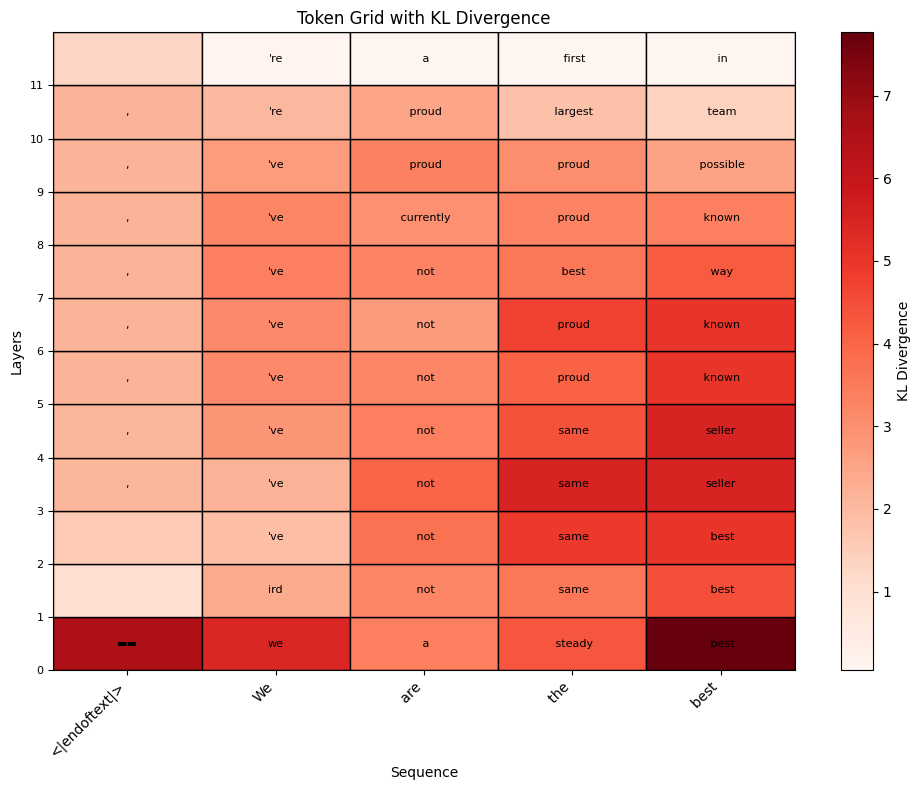

In [20]:
text = "We are the best"
tokens, top_unebedded_residual_stream_caches, kl_divergences = logit_lens_analysis(text)
plot_logit_lens(gpt2_tokenizer, tokens[0], top_unebedded_residual_stream_caches, kl_divergences)

<details>
<summary>Do you see anything interesting in these diagrams?</summary>
In which layer does the model start to predict "Bob" vs "Potter"? Do you have any idea why?
Try to play around with different prompts and see what happens.
</details>

## Linear Separability of the Activations
The second thing we will look at is the linear separability of the activations. This is a measure of how well the activations of a layer can be used to predict what is going on in the transformer.
Here, we have a dataset with different prompts, corresponding to different simple tasks, that a transformer might be doing:
  - inverting words to their opposite
  - translating words into German
This linear separability is necessary for linear probes and activation addition to work.

In [21]:
steering_prompt_pairs = [
    ["fast : slow", "fast : schnell"],
    ["cold : warm", "cold : kalt"],
    ["big : small", "big : groß"],
    ["happy : sad", "happy : froh"],
    ["light : dark", "light : hell"],
    ["loud : quiet", "loud : laut"],
    ["new : old", "new : neu"],
    ["rich : poor", "rich : reich"],
    ["strong : weak", "strong : stark"],
    ["young : old", "young : jung"],
    ["clean : dirty", "clean : rein"],
    ["dry : wet", "dry : trocken"],
    ["full : empty", "full : voll"],
    ["good : bad", "good : gut"],
    ["hard : soft", "hard : hart"],
    ["heavy : light", "heavy : schwer"],
    ["high : low", "high : hoch"],
    ["long : short", "long : lang"],
    ["right : wrong", "right : richtig"],
    ["rough : smooth", "rough : rau"],
    ["sharp : dull", "sharp : scharf"],
    ["thick : thin", "thick : dick"],
    ["wide : narrow", "wide : breit"],
    ["brave : cowardly", "brave : mutig"],
    ["calm : angry", "calm : ruhig"],
    ["clever : stupid", "clever : klug"],
    ["cruel : kind", "cruel : grausam"],
    ["deep : shallow", "deep : tief"],
    ["early : late", "early : früh"],
    ["easy : hard", "easy : leicht"],
    ["fake : real", "fake : falsch"],
    ["far : near", "far : weit"],
    ["first : last", "first : erster"],
    ["free : captive", "free : frei"],
    ["front : back", "front : vorne"],
    ["great : terrible", "great : toll"],
    ["hot : cold", "hot : heiß"],
    ["large : small", "large : groß"],
    ["left : right", "left : links"],
    ["loose : tight", "loose : locker"],
    ["lost : found", "lost : verloren"],
    ["low : high", "low : niedrig"],
    ["major : minor", "major : wichtig"],
    ["many : few", "many : viele"],
    ["open : closed", "open : offen"],
    ["past : future", "past : vergangen"],
    ["peace : war", "peace : frieden"],
    ["quick : slow", "quick : schnell"],
    ["raw : cooked", "raw : roh"],
    ["safe : dangerous", "safe : sicher"],
    ["same : different", "same : gleich"],
    ["short : tall", "short : kurz"],
    ["sick : healthy", "sick : krank"],
    ["simple : complex", "simple : einfach"],
    ["single : married", "single : ledig"],
    ["slow : fast", "slow : langsam"],
    ["small : big", "small : klein"],
    ["smart : dumb", "smart : klug"],
    ["soft : hard", "soft : weich"],
    ["sour : sweet", "sour : sauer"],
    ["start : end", "start : anfang"],
    ["stop : go", "stop : halt"],
    ["sweet : sour", "sweet : süß"],
    ["tall : short", "tall : groß"],
    ["tame : wild", "tame : zahm"],
    ["thin : fat", "thin : dünn"],
    ["top : bottom", "top : oben"],
    ["tough : tender", "tough : zäh"],
    ["true : false", "true : wahr"],
    ["ugly : beautiful", "ugly : hässlich"],
    ["urban : rural", "urban : städtisch"],
    ["used : new", "used : gebraucht"],
    ["useful : useless", "useful : nützlich"],
    ["valid : invalid", "valid : gültig"],
    ["vast : tiny", "vast : riesig"],
    ["vegan : carnivore", "vegan : vegan"],
    ["visible : invisible", "visible : sichtbar"],
    ["vital : trivial", "vital : wichtig"],
    ["vivid : dull", "vivid : lebhaft"],
    ["warm : cool", "warm : warm"],
    ["waste : save", "waste : abfall"],
    ["weak : strong", "weak : schwach"],
    ["wealth : poverty", "wealth : reichtum"],
    ["weird : normal", "weird : seltsam"],
    ["wet : dry", "wet : nass"],
    ["white : black", "white : weiß"],
    ["whole : part", "whole : ganz"],
    ["wide : narrow", "wide : breit"],
    ["wild : tame", "wild : wild"],
    ["win : lose", "win : sieg"],
    ["wise : foolish", "wise : weise"],
    ["woman : man", "woman : frau"],
    ["work : play", "work : arbeit"],
    ["wrong : right", "wrong : falsch"],
    ["yes : no", "yes : ja"],
    ["young : old", "young : jung"],
    ["zero : one", "zero : null"],
]

In this dataset, the relevant token, where the task becomes clear is the first token after prompt.
For creating steering vectors for example, it is important to average over those tokens, that carrie the information, that one wants to infuse into the network.

Now it is your turn to retrieve the relevant activations from the datasset of different tasks:
 - find out the relevant token, where the task becomes clear (this is already implemented)
 - get the activations in the residual stream, for the relevant token for each layer
 - combine all of the activations into a single tensor, and return it


In [22]:
def prompt_to_residual_stream_activations(prompt, demarcation_token):
    """
    Computes the residual stream activations for the first token after the demarkation token in the prompt.

    Args:
        prompt (str): The input prompt string.
        demarcation_token (int): The token ID representing the demarcation point in the prompt.

    Returns:
        torch.Tensor: The residual stream activations for the final token in the prompt.
    """
    # Tokenize the prompt and convert it to a list
    tokens = gpt2_small.to_tokens(prompt)[0].tolist()

    # Find the position of the demarcation token in the tokenized prompt
    demarcation_position = tokens.index(demarcation_token)

    # Truncate the tokens up to the demarcation token and include two additional tokens
    tokens = tokens[: demarcation_position + 2]

    # Convert the tokens to a tensor and add a batch dimension
    tokens = t.tensor(tokens).unsqueeze(0)

    # Run the model with the truncated tokens and obtain the final logits and cache
    final_logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)
    # Get the number of layers in the model
    num_layers = len(gpt2_small.blocks)

    # Extract the residual stream activations from the cache for each layer
    residual_stream_caches = [cache[f"blocks.{i}.ln2.hook_normalized"] for i in range(num_layers)]
    # Stack the residual stream activations along a new dimension
    residual_stream_caches = t.stack(residual_stream_caches, dim=1)

    # Extract the residual stream activations for the final token
    final_token_residual_stream_caches = residual_stream_caches[-1]

    return final_token_residual_stream_caches


test_prompt_to_residual_stream_activations(prompt_to_residual_stream_activations, gpt2_small)

Prompt to residual stream activations test passed


<details>
<summary>Solution</summary>

```python
def prompt_to_residual_stream_activations(prompt, demarcation_token):
    """
    Computes the residual stream activations for the first token after the demarkation token in the prompt.

    Args:
        prompt (str): The input prompt string.
        demarcation_token (int): The token ID representing the demarcation point in the prompt.

    Returns:
        torch.Tensor: The residual stream activations for the final token in the prompt.
    """
    # Tokenize the prompt and convert it to a list
    tokens = gpt2_small.to_tokens(prompt)[0].tolist()

    # Find the position of the demarcation token in the tokenized prompt
    demarcation_position = tokens.index(demarcation_token)

    # Truncate the tokens up to the demarcation token and include two additional tokens
    tokens = tokens[:demarcation_position + 2]

    # Convert the tokens to a tensor and add a batch dimension
    tokens = t.tensor(tokens).unsqueeze(0)

    # Run the model with the truncated tokens and obtain the final logits and cache
    final_logits, cache = gpt2_small.run_with_cache(tokens, remove_batch_dim=True)

    # Get the number of layers in the model
    num_layers = len(gpt2_small.blocks)

    # Extract the residual stream activations from the cache for each layer
    residual_stream_caches = [cache[f"blocks.{i}.ln2.hook_normalized"] for i in range(num_layers)]

    # Stack the residual stream activations along a new dimension
    residual_stream_caches = t.stack(residual_stream_caches, dim=1)

    # Extract the residual stream activations for the final token
    final_token_residual_stream_caches = residual_stream_caches[-1]

    return final_token_residual_stream_caches
```

</details>

In [23]:
def crate_activation_dataset(prompt_pairs, demarkation_string):
    a_activations = []
    b_activations = []

    demarkation_token = gpt2_tokenizer.encode(demarkation_string)[-1]

    for truth_prompt, lie_prompt in prompt_pairs:
        a_activations.append(prompt_to_residual_stream_activations(truth_prompt, demarkation_token))
        b_activations.append(prompt_to_residual_stream_activations(lie_prompt, demarkation_token))

    a_activations = t.stack(a_activations)
    b_activations = t.stack(b_activations)
    return a_activations, b_activations


demarkation_string = " :"
a_activations, b_activations = crate_activation_dataset(steering_prompt_pairs, demarkation_string)

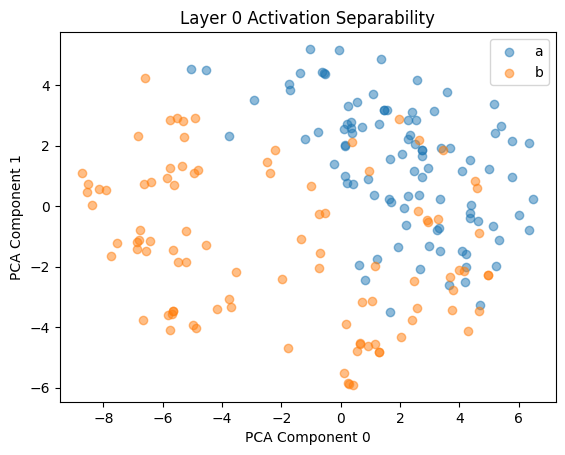

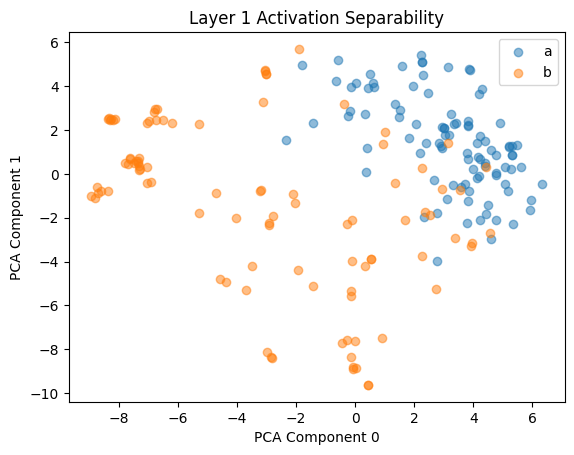

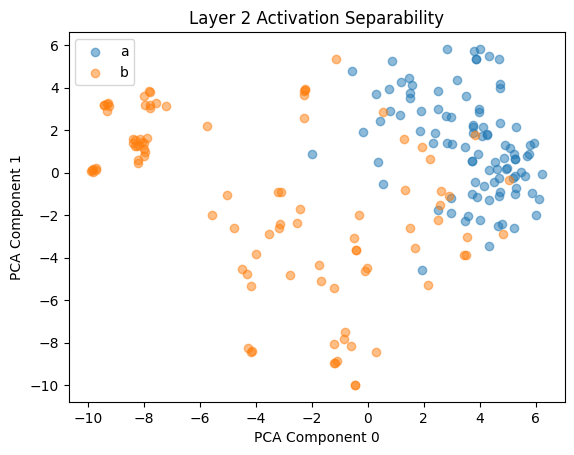

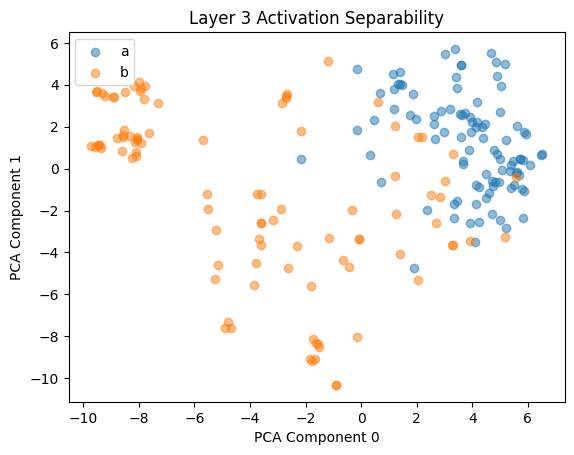

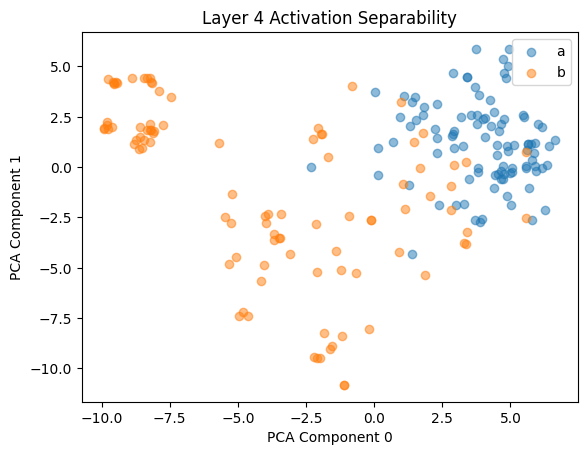

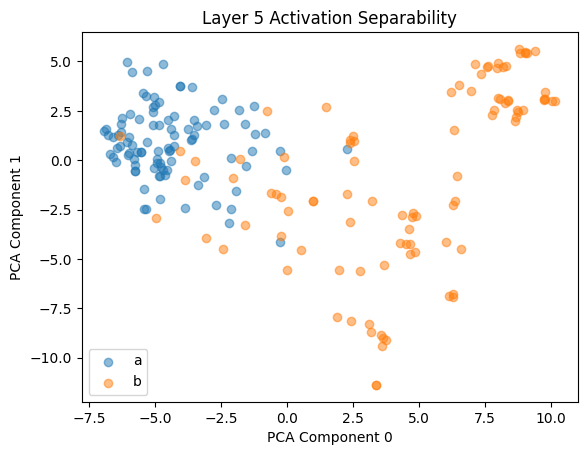

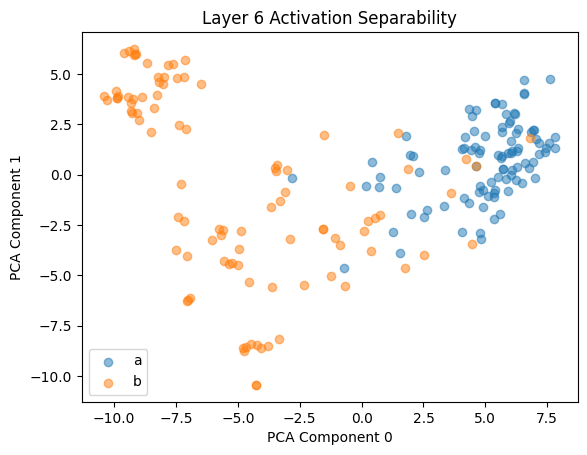

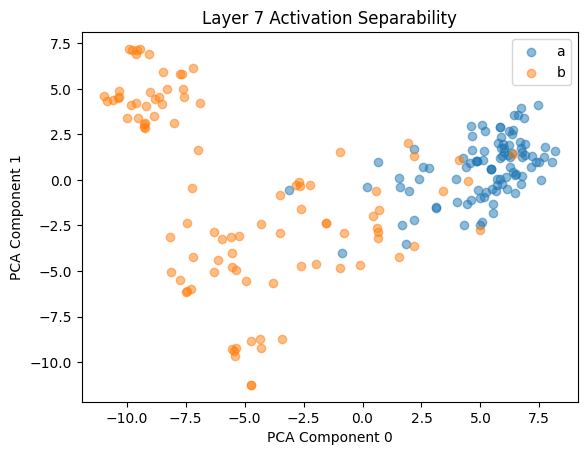

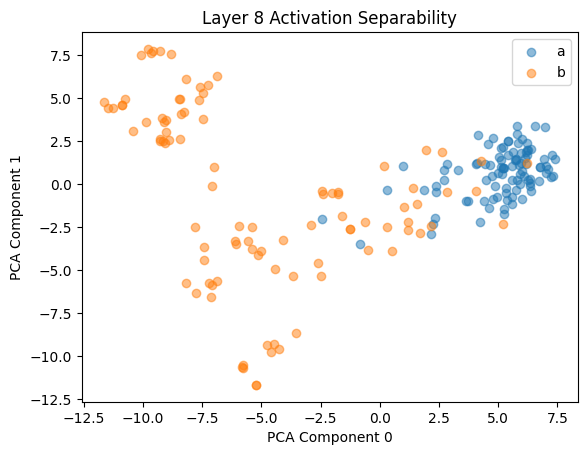

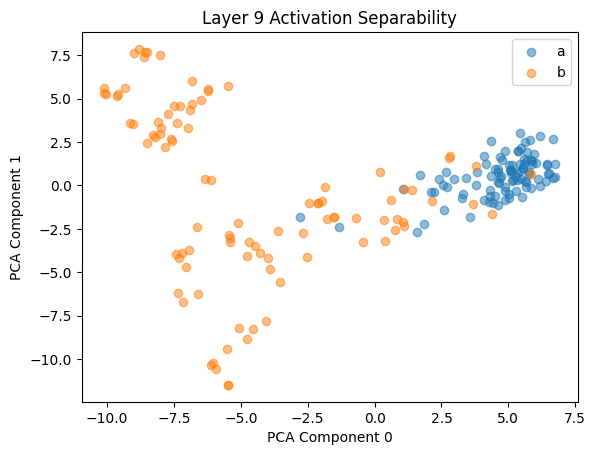

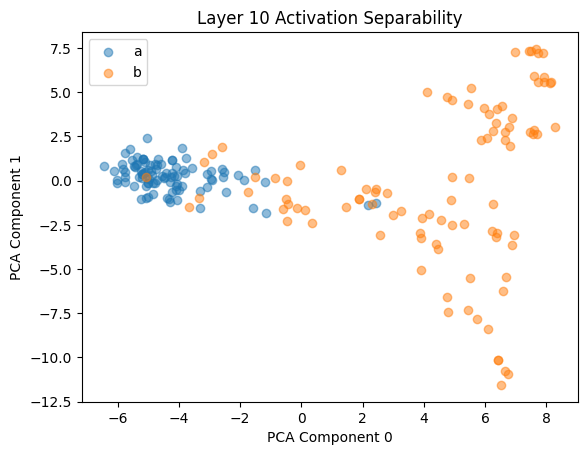

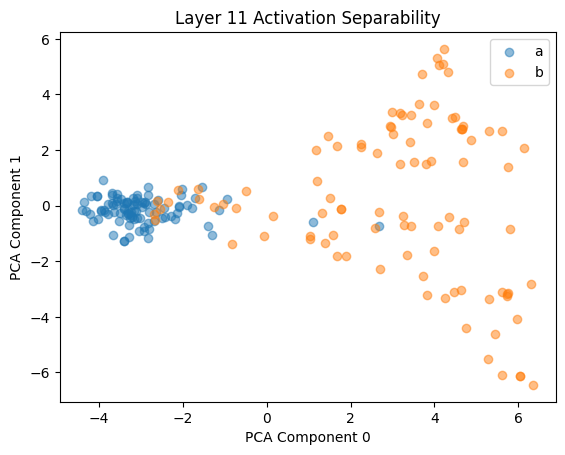

In [30]:
def plot_activation_seperability(a_activations, b_activations, layer, pca_com1=0, pca_com2=1):
    all_activations = t.cat([a_activations, b_activations], dim=0)
    all_activations = all_activations[:, layer, :]
    pca = PCA(n_components=2)
    pca.fit(all_activations)
    a_activations_pca = pca.transform(a_activations[:, layer, :])
    b_activations_pca = pca.transform(b_activations[:, layer, :])
    plt.scatter(
        a_activations_pca[:, pca_com1], a_activations_pca[:, pca_com2], label="a", alpha=0.5
    )
    plt.scatter(
        b_activations_pca[:, pca_com1], b_activations_pca[:, pca_com2], label="b", alpha=0.5
    )
    plt.legend()
    plt.title(f"Layer {layer} Activation Separability")
    plt.xlabel(f"PCA Component {pca_com1}")
    plt.ylabel(f"PCA Component {pca_com2}")
    plt.show()


for i in range(12):plot_activation_seperability(a_activations, b_activations, layer=i)

<details>
<summary>Why do we plot the primary components instead of training a linear classifier?</summary>
When the number of dimensions exceeds the number of datapoints, you can just find a linear separation for the data without any generalisation to other datapoints. This does not tell us anything about the different representations of the data in the network.
By restricting ourselves to the dimensions along which the dataset has the most variance, we only see the most important dimensions along which the data varies.
</details>
<details>
<summary>Play around with the layers and PCA components</summary>
Why do you think the activations are more separable in some layers than in others?
</details>